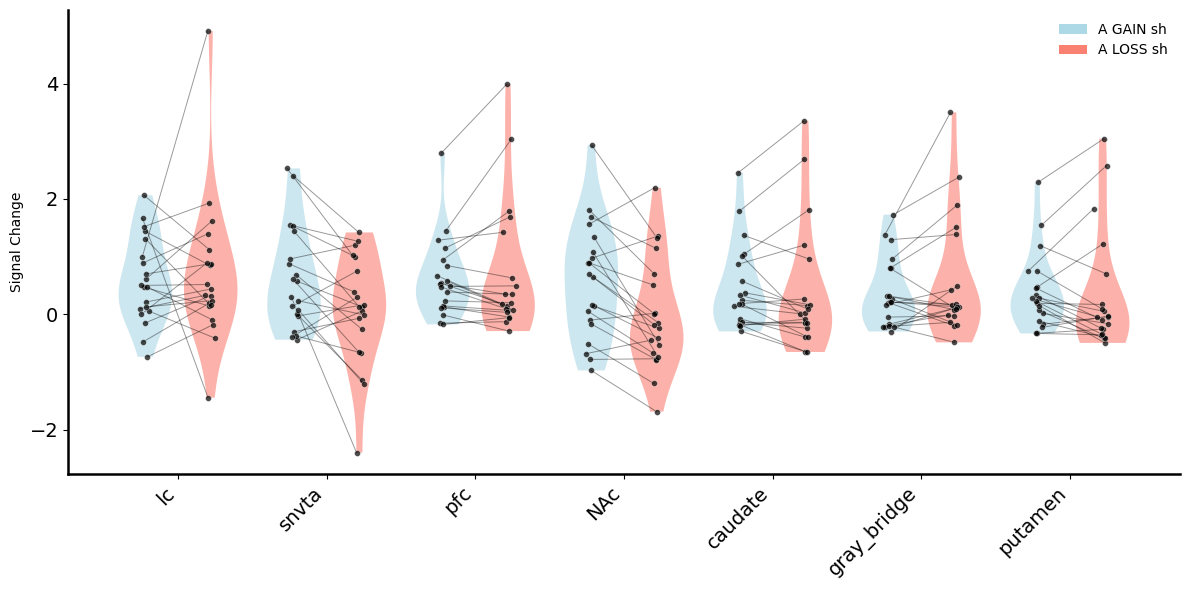

In [22]:
# %% Load saved source data and reproduce Fig 4 violin+slope (Gain → Loss)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch

in_xlsx = os.path.join(data_dir, "output", "SourceData_Fig4_SH_GainLoss.xlsx")
df_wide_in = pd.read_excel(in_xlsx, sheet_name="SourceData_Wide")

roi_order = ["lc", "snvta", "pfc", "NAc", "caudate", "gray_bridge", "putamen"]
GAIN_LABEL, LOSS_LABEL = "A GAIN sh", "A LOSS sh"

# Reconstruct subject arrays (per ROI) from the wide table
all_roi_gain_subject = [df_wide_in[f"Gain_{r}"].to_numpy(dtype=float) for r in roi_order]
all_roi_loss_subject = [df_wide_in[f"Loss_{r}"].to_numpy(dtype=float) for r in roi_order]

# Optional mean±SEM for y-limits (consistent with your earlier logic)
means = np.array([[np.nanmean(g), np.nanmean(l)] for g, l in zip(all_roi_gain_subject, all_roi_loss_subject)])
sems  = np.array([[np.nanstd(g, ddof=1)/np.sqrt(np.isfinite(g).sum()) if np.isfinite(g).sum() > 1 else np.nan,
                   np.nanstd(l, ddof=1)/np.sqrt(np.isfinite(l).sum()) if np.isfinite(l).sum() > 1 else np.nan]
                  for g, l in zip(all_roi_gain_subject, all_roi_loss_subject)])
max_y = np.nanmax(means + sems)
min_y = np.nanmin(means - sems)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_order))
offset = 0.22
vwidth = 0.36
JITTER_SD = 0.02

gain_color, loss_color = "lightblue", "salmon"

for i, r in enumerate(roi_order):
    gain = np.asarray(all_roi_gain_subject[i], float)
    loss = np.asarray(all_roi_loss_subject[i], float)

    # violins
    parts = ax.violinplot([gain, loss],
                          positions=[x[i] - offset, x[i] + offset],
                          widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    parts["bodies"][0].set_facecolor(gain_color); parts["bodies"][0].set_alpha(0.6); parts["bodies"][0].set_edgecolor("none")
    parts["bodies"][1].set_facecolor(loss_color); parts["bodies"][1].set_alpha(0.6); parts["bodies"][1].set_edgecolor("none")

    # paired slope + points (same jitter per subject)
    mask = np.isfinite(gain) & np.isfinite(loss)
    gain_p = gain[mask]
    loss_p = loss[mask]

    rng = np.random.default_rng(7 + i)  # ROI-specific seed for reproducibility
    base = rng.normal(0, JITTER_SD, size=gain_p.size)
    xg = x[i] - offset + base
    xl = x[i] + offset + base

    for xgi, xli, ygi, yli in zip(xg, xl, gain_p, loss_p):
        ax.plot([xgi, xli], [ygi, yli], color="k", alpha=0.4, lw=0.7, zorder=4)

    ax.scatter(xg, gain_p, s=18, alpha=0.7, color="k", linewidth=0.3, edgecolor="white", zorder=5)
    ax.scatter(xl, loss_p, s=18, alpha=0.7, color="k", linewidth=0.3, edgecolor="white", zorder=5)

# style
ax.set_xticks(x)
ax.set_xticklabels(roi_order, rotation=45, ha="right")
ax.set_ylabel("Signal Change")
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(5))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.8)
ax.spines["bottom"].set_linewidth(1.8)

ax.legend(handles=[Patch(facecolor=gain_color, label=GAIN_LABEL),
                   Patch(facecolor=loss_color, label=LOSS_LABEL)],
          frameon=False, loc="upper right")

plt.tight_layout()
out_png = os.path.join(data_dir, "output", "roi_gl_violin_slope_from_source.png")
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()